# AWS Network Flow 

## Introduction
Let a customer currently have a batch of data that is stored in Amazon's S3 storage, where some data are frequently accessed and some are infrequent. There are multiple different regions where the customer's data can be stored. Each of these locations will cost a certain amount of money per gigabyte(GB) of data. There is also a cost to transfer data between two regions.


## Defining the problem

### Defining ```data_order```, ```start_amount```, ```transfer_cost```, and ```BUCKET_LIMIT```
Let the user start off with 6 different regions to work with, specified as ```data_order[i]```. The user can also have two types of data, frequently used and infrequently used. For each unique region ```i```, the user has ```start_amount[i][0]``` GBs of frequently used data and ```start_amount[i][1]``` GBs of infrequently used data. 

Similarily for the storage cost, it costs ```storage_cost[i][k]``` dollars for storing data in location ```data_order[i]``` for frequently used data if ```k = 0``` and for infrequently used data if ```k = 1```.

```transfer_cost[i][j]``` represents the amount it takes to transfer 1 GB of data from ```data_order[i]``` to ```data_order[j]```. This amount is consistent regardless of data usage frequency.

```BUCKET_LIMIT``` simply represents the maximum amount allowed at a single bucket when solving the LP.

Feel free to change any of these values as you see fit!

### Rules
The user wants to move all their data from their current storage buckets into another one. This means that all of the data in ```start_amount``` must move, and also implies that the data can't move into another bucket that originally already has data.

### Cost Values
The cost values and storage regions are gathered from [AWS S3](https://aws.amazon.com/s3/pricing/). 

In [9]:
from pulp import *
import networkx as nx
import matplotlib.pyplot as plt

prob = LpProblem('AWS_Storage_Network_Flow', LpMinimize)
storages = range(0,6)
types = range(0,2)

data_order = ["US East Ohio",
              "Asia Pacific Osaka",
              "US West North California",
              "Europe London",
              "South America Sao Paulo",
              "Middle East UAE"]

# Let varible x_{i,j,k} represent number of GBs of data moved from data_order[i] to data_order[j],
# Where k = 0 if the data is frequently used and k = 1 if infrequently used.
lp_vars = LpVariable.dicts("vars", (storages,storages,types))


# Storage cost of locations in data_order, represented as [frequently, infrequently].
storage_cost = [[0.023, 0.0125], 
                [0.025, 0.0138],
                [0.026, 0.0144],
                [0.024, 0.0131],
                [0.0405, 0.0221],
                [0.025, 0.0138]]

# Transfer_cost[i][j] represents cost to transfer from locatoin data_order[i] to data_order[j].
transfer_cost = [[0, 0.02, 0.02, 0.02, 0.02, 0.02],
                [0.09, 0, 0.09, 0.09, 0.09, 0.09],
                [0.02, 0.02, 0, 0.02, 0.02, 0.02],
                [0.02, 0.02, 0.02, 0, 0.02, 0.02],
                [0.138, 0.138, 0.138, 0.138, 0, 0.138],
                [0.085, 0.085, 0.085, 0.085, 0.085, 0]]

# Number of GB of data that is frequently used and infrequently used.
# start_amount[i][j] represents the amount of data in data_order[i], with type j. 
start_amount = [[0, 19],
                [0, 5],
                [17, 0],
                [5, 18],
                [12, 0],
                [0, 0]]
BUCKET_LIMIT = 15

# Objective to minimize storage cost per gb stored and transfer cost per gb transferred
prob += (sum((storage_cost[j][k] + transfer_cost[i][j]) * lp_vars[i][j][k] for i in storages
                     for j in range(len(storages)) for k in types))


for k in types:
    
    # Constraints
    for i in storages:    
        # Check sum of amount of data from storage 'i' to 'j' is equal to starting amount in storage 'i',
        # Where storage 'i' has nothing remaining.
        prob += sum(lp_vars[i][j][k] if i != j else 0 for j in storages) == start_amount[i][k]
        
        # Add a limit for storage demand.
        prob += sum(lp_vars[j][i][k] for j in storages) <= BUCKET_LIMIT

        # No incoming data if storage has data in starting amount
        if start_amount[i][k] != 0:
            prob += sum(lp_vars[j][i][k] for j in storages) == 0
        
        # Lower limit of single container storage.
        for j in storages:
            prob += lp_vars[i][j][k] >= 0
            
prob.solve()

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --cpxlp /tmp/90f12082eeaf4ad094b9858c8c45b3d0-pulp.lp -o /tmp/90f12082eeaf4ad094b9858c8c45b3d0-pulp.sol
Reading problem data from '/tmp/90f12082eeaf4ad094b9858c8c45b3d0-pulp.lp'...
102 rows, 72 columns, 240 non-zeros
218 lines were read
GLPK Simplex Optimizer, v4.65
102 rows, 72 columns, 240 non-zeros
Preprocessing...
12 rows, 24 columns, 42 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12
      0: obj =   4.715600000e+00 inf =   4.600e+01 (2)
      7: obj =   4.794200000e+00 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (114020 bytes)
Writing basic solution to '/tmp/90f12082eeaf4ad094b9858c8c45b3d0-pulp.sol'...


1

# Results
The cell below will generate graphs and calculate the final costs for transferring the existing data into different regions. 
> Note: Due to the limitations of NetworkX, sometimes the lables will overlap. Re-run the cell to generate a new graph . NetworkX also doesn't let users give weighted nodes while also having additional labelled names. (https://stackoverflow.com/questions/56294715/networkx-graph-plot-node-weights)  

## Reading the graphs 
### Starting Graphs
The weighted edges represent the cost per GB it'll take to move the data to another region. This is calculated by taking the sum of the transfer cost and storage cost. Remember only nodes without data in the beginning can take in data.
### End Graphs
The directed weighted edges represent the number of GBs of data that should move from the beginning node to the end node. This shows the optimal solution in which to transfer data.

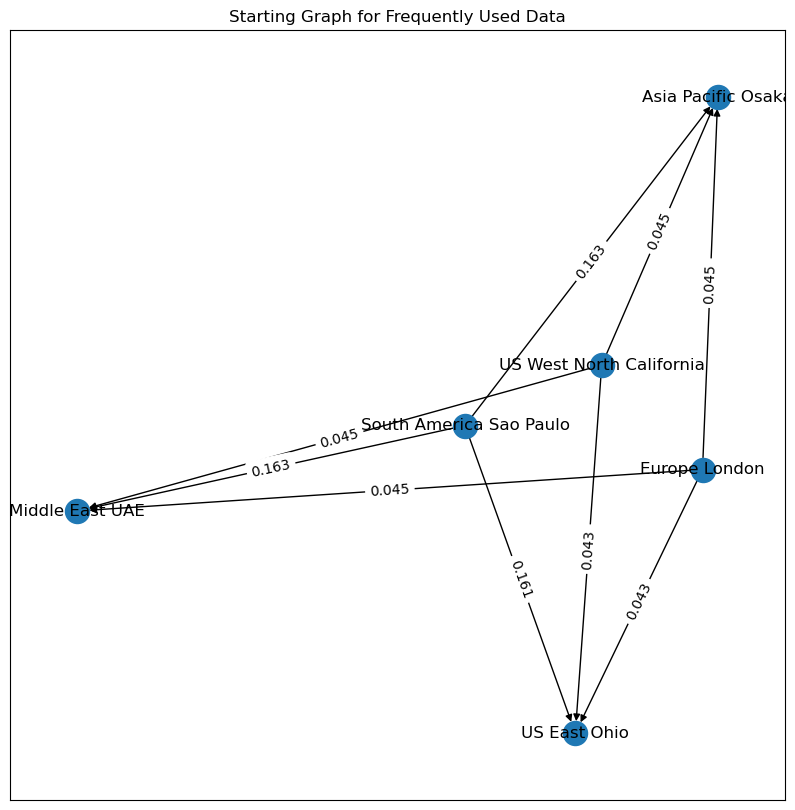

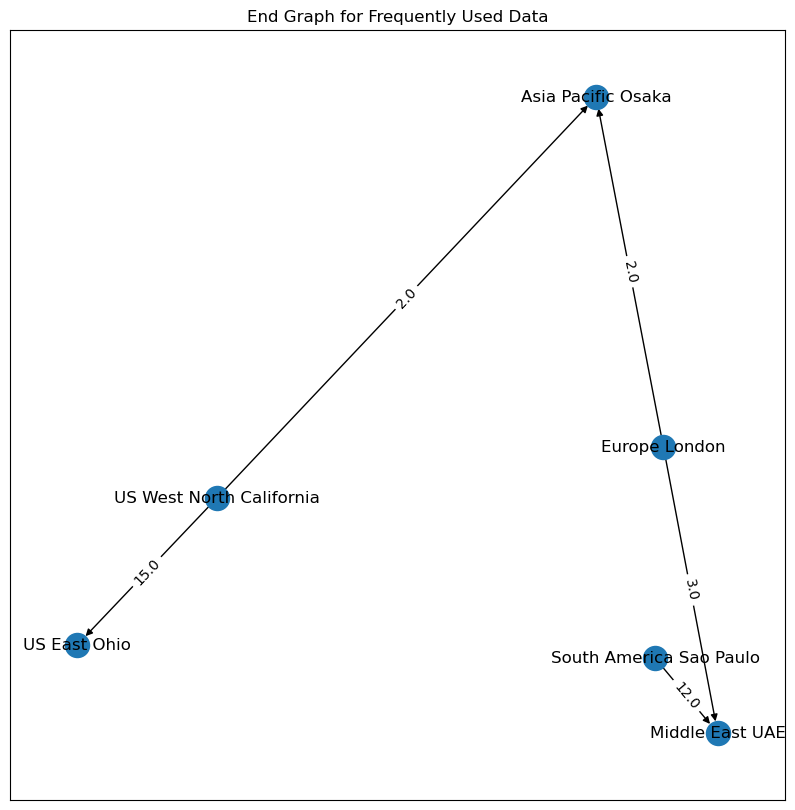

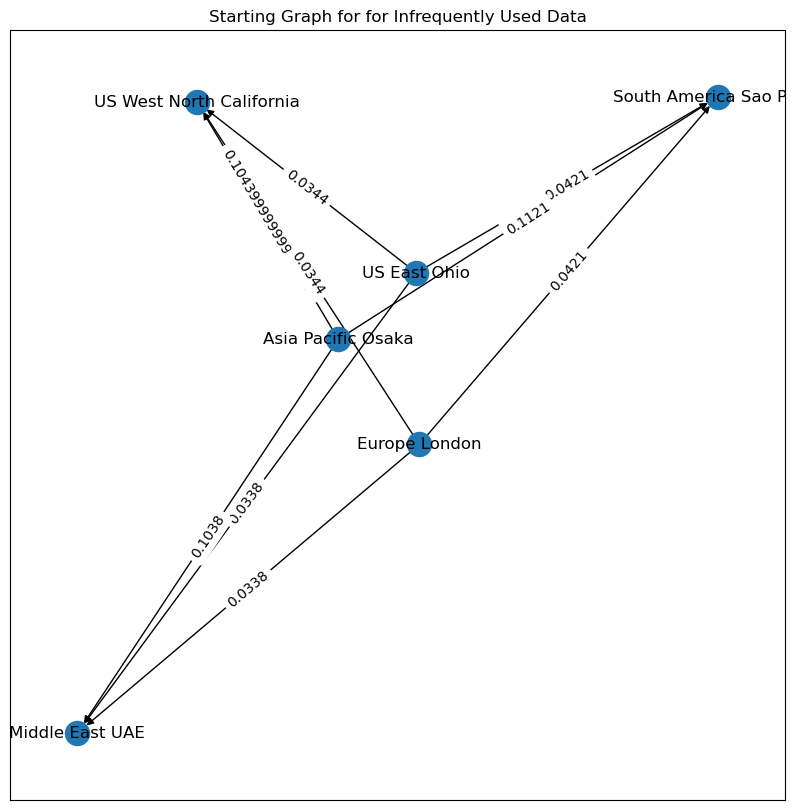

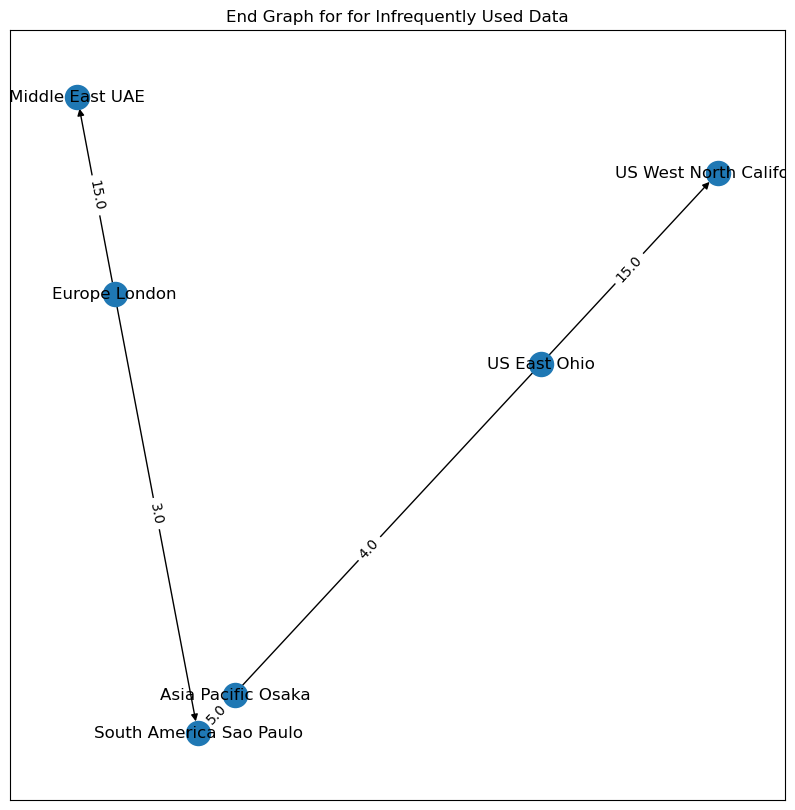

Cost for moving frequently used data:  0.8200000000000001
Cost for moving infrequently used data:  0.6882
Total cost:  1.5082


In [11]:
# Print Graphs
for k in types:

    # Starting Graph
    G = nx.DiGraph()
    for i in storages:
        if start_amount[i][k] != 0: 
            for j in storages:
                if start_amount[j][k] == 0:
                    # print('adding edge' + data_order[i] + data_order[j])
                    G.add_edge(data_order[i], data_order[j], weight=transfer_cost[i][j] + storage_cost[j][k])

    # Enables networkX to show weighted edges and multiple graphs at once.
    pos=nx.spring_layout(G)
    plt.figure(k*2, figsize=(10,10))
    plt.title('Starting Graph for ' + ('Frequently Used Data' if k == 0 else 'for Infrequently Used Data'))
    nx.draw_networkx(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()
    

    # End Graph 
    H = nx.DiGraph()
    for i in storages:
        for j in storages:
            if lp_vars[i][j][k].value() != 0:
                H.add_edge(data_order[i], data_order[j], weight=lp_vars[i][j][k].value())
                
    # Enables networkX to show weighted edges and multiple graphs at once.
    pos=nx.spring_layout(H)
    plt.figure(k*2+1,figsize=(10,10))
    plt.title('End Graph for ' + ('Frequently Used Data' if k == 0 else 'for Infrequently Used Data'))
    nx.draw_networkx(H,pos)
    labels = nx.get_edge_attributes(H,'weight')
    nx.draw_networkx_edge_labels(H,pos,edge_labels=labels)
    plt.show()

# Calculate and print total cost
res = [0,0]
for k in types:
    for i in storages:
        for j in storages:
            res[k] += lp_vars[i][j][k].value() * storage_cost[j][k]

            
print("Cost for moving frequently used data: ", res[0])
print("Cost for moving infrequently used data: ", res[1])
print("Total cost: ", sum(res)) 
